# Funding choropleth map

Some useful imports

In [1]:
import requests as r
import pandas as pd
import json
import folium
import os
import re

## Data cleaning

The files containing the funds of universities and the swiss cantons topology.

In [2]:
funding_file = 'P3_GrantExport.csv'
cantons_file = 'ch-cantons.topojson.json'

When reading the CSV file we select only the columns we are interested in, namely: "Project Number", "Institution", "University", and "Approved Amount"

In [3]:
df = pd.read_csv(funding_file, sep=';', index_col=0, usecols=[0,6,7,13])

In [4]:
df.head()

Institution  \
﻿"Project Number"                                                      
1                                                                NaN   
4                  Faculté de Psychologie et des Sciences de l'Ed...   
5                  Kommission für das Corpus philosophorum medii ...   
6                  Abt. Handschriften und Alte Drucke Bibliothek ...   
7                                       Schweiz. Thesauruskommission   

                                                University Approved Amount  
﻿"Project Number"                                                           
1                                     Nicht zuteilbar - NA        11619.00  
4                                Université de Genève - GE        41022.00  
5                  NPO (Biblioth., Museen, Verwalt.) - NPO        79732.00  
6                                   Universität Basel - BS        52627.00  
7                  NPO (Biblioth., Museen, Verwalt.) - NPO       120042.00

We convert the elements of the "Approved Amount" column to numeric values, then we remove entries without a proper university name or with no readable amount.

In [5]:
df['Approved Amount'] = pd.to_numeric(df['Approved Amount'], errors='coerce')

In [6]:
df = df[(df.University != 'Nicht zuteilbar - NA') & pd.notnull(df.University) & pd.notnull(df['Approved Amount'])]

In [7]:
df.head()

Institution  \
﻿"Project Number"                                                      
4                  Faculté de Psychologie et des Sciences de l'Ed...   
5                  Kommission für das Corpus philosophorum medii ...   
6                  Abt. Handschriften und Alte Drucke Bibliothek ...   
7                                       Schweiz. Thesauruskommission   
8                  Séminaire de politique économique, d'économie ...   

                                                University  Approved Amount  
﻿"Project Number"                                                            
4                                Université de Genève - GE          41022.0  
5                  NPO (Biblioth., Museen, Verwalt.) - NPO          79732.0  
6                                   Universität Basel - BS          52627.0  
7                  NPO (Biblioth., Museen, Verwalt.) - NPO         120042.0  
8                              Université de Fribourg - FR          53009.0

## Fill and compute

We are using the google geocode API to get most of our canton information. To make this work without giving out any information on github you have to export a valid API key.

In [8]:
wikimedia_cantons_url = 'https://fr.wikipedia.org/wiki/Canton_suisse'
geocoding_url = 'https://maps.googleapis.com/maps/api/geocode/json'
geocoding_key = os.environ.get('GEOCODING_KEY')
if geocoding_key is None:
    print('No key found: `export GEOCODING_KEY=...` before launching jupyter.')
    raise

We gather all the cantons' acronyms and full names, from the topology file.

In [9]:
cantons = []
with open(cantons_file) as file:    
    for canton in json.load(file)['objects']['cantons']['geometries']:
        cantons.append((canton['id'], canton['properties']['name'].split('/')))
assert len(cantons) == 26
cantons_acronyms = [c[0] for c in cantons]

A list of all unique universities

In [10]:
universities = df.University.unique()
universities

array(['Université de Genève - GE',
       'NPO (Biblioth., Museen, Verwalt.) - NPO', 'Universität Basel - BS',
       'Université de Fribourg - FR', 'Universität Zürich - ZH',
       'Université de Lausanne - LA', 'Universität Bern - BE',
       'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL',
       'Université de Neuchâtel - NE', 'ETH Zürich - ETHZ',
       'Inst. de Hautes Etudes Internat. et du Dév - IHEID',
       'Universität St. Gallen - SG', 'Weitere Institute - FINST',
       'Firmen/Privatwirtschaft - FP',
       'Pädagogische Hochschule Graubünden - PHGR', 'EPF Lausanne - EPFL',
       'Pädagogische Hochschule Zürich - PHZFH', 'Universität Luzern - LU',
       'Schweiz. Institut für Kunstwissenschaft - SIK-ISEA',
       'SUP della Svizzera italiana - SUPSI',
       'HES de Suisse occidentale - HES-SO',
       'Robert Walser-Stiftung Bern - RWS', 'Paul Scherrer Institut - PSI',
       'Pädagogische Hochschule St. Gallen - PHSG',
       'Eidg. Anstalt für Wasserversorgun

This function will read the result of the google api and get out the canton initials back.

In [11]:
def fetch_canton(value, clue, cantons, field='short_name', tpe='administrative_area_level_1', short_long_sep='-'):
        
    def req(address):
        return r.get(geocoding_url, params={'key': geocoding_key, 'address': address}).json()
    
    def extract(res):
        for location in res:
            canton = [elem[field] 
                      for elem in location['address_components'] 
                      if tpe in elem['types'] and elem[field] in cantons]
            if len(canton):
                return canton[0]
        return None
    
    full_query = req(value + ', ' + clue)
    if len(full_query['results']):
        return extract(full_query['results'])
    
    value_parts = value.split(short_long_sep)
    if len(value_parts) > 1:
        
        short_query = req(value_parts[1] + ', ' + clue)
        if len(short_query['results']):
            return extract(short_query['results'])
    
    return None

First we do an heuristic search on a university name to see if it contains a canton's name, if not we make a request to Google's Geocoding API.

In [12]:
universities_cantons = {}
for uni in universities:
    for acronym, names in cantons:
        for name in names:
            if name in uni:
                universities_cantons[uni] = acronym
    if not universities_cantons.get(uni):
        universities_cantons[uni] = fetch_canton(re.sub(r'\([^)]*\)', 'switzerland', uni), 'Switzerland', cantons_acronyms)

The following code sends requests to Google's Geocoding API for all universities without a canton already found. The regex gets rid of the parenthesis when querying in order to ont flood the api with too much useless info.
Also the function fetch_canton() adds a "clue", here it is "Switzerland", to the query.

In [13]:
universities_cantons

{'AO Research Institute - AORI': None,
 'Allergie- und Asthmaforschung - SIAF': None,
 'Berner Fachhochschule - BFH': 'BE',
 'Biotechnologie Institut Thurgau - BITG': 'TG',
 "Centre de rech. sur l'environnement alpin - CREALP": 'UR',
 'EPF Lausanne - EPFL': 'VD',
 'ETH Zürich - ETHZ': 'ZH',
 'Eidg. Anstalt für Wasserversorgung - EAWAG': None,
 'Eidg. Forschungsanstalt für Wald,Schnee,Land - WSL': 'ZH',
 'Eidg. Hochschulinstitut für Berufsbildung - EHB': None,
 'Eidg. Material und Prüfungsanstalt - EMPA': 'ZH',
 'Ente Ospedaliero Cantonale - EOC': None,
 'Fachhochschule Kalaidos - FHKD': None,
 'Fachhochschule Nordwestschweiz (ohne PH) - FHNW': None,
 'Fachhochschule Ostschweiz - FHO': None,
 'Facoltà di Teologia di Lugano - FTL': None,
 'Fernfachhochschule Schweiz (Mitglied SUPSI) - FFHS': None,
 'Firmen/Privatwirtschaft - FP': None,
 'Forschungsanstalten Agroscope - AGS': None,
 'Forschungsinstitut für Opthalmologie - IRO': None,
 'Forschungsinstitut für biologischen Landbau - FIBL': 

In [14]:
df['Cantons'] = df.University.apply(universities_cantons.get)

Here is the percentage of universities we have located.

In [15]:
pd.notnull(df.Cantons).sum() / len(df.Cantons)

0.95014808524739558

And the dataframe containing the canton linked to the institution.

In [16]:
df.head()

Institution  \
﻿"Project Number"                                                      
4                  Faculté de Psychologie et des Sciences de l'Ed...   
5                  Kommission für das Corpus philosophorum medii ...   
6                  Abt. Handschriften und Alte Drucke Bibliothek ...   
7                                       Schweiz. Thesauruskommission   
8                  Séminaire de politique économique, d'économie ...   

                                                University  Approved Amount  \
﻿"Project Number"                                                             
4                                Université de Genève - GE          41022.0   
5                  NPO (Biblioth., Museen, Verwalt.) - NPO          79732.0   
6                                   Universität Basel - BS          52627.0   
7                  NPO (Biblioth., Museen, Verwalt.) - NPO         120042.0   
8                              Université de Fribourg - FR          53009.0   

                  Cantons  
﻿"Project Number"          
4                      GE  
5                      FR  
6                      BS  
7                      FR  
8                      FR

## Preparing the Data

The first part of visualizing the data is to get out how much investement per canton has be given. 

In [17]:
df_funding = df.groupby('Cantons').sum().reindex(cantons_acronyms, fill_value=0).reset_index()
df_funding.describe()

Approved Amount
count     2.600000e+01
mean      4.726684e+08
std       9.176627e+08
min       0.000000e+00
25%       2.388928e+05
50%       1.040773e+07
75%       3.162207e+08
max       3.572673e+09

For the data to be put on a linear scale I apply the log function on the Approved amount to make it linear. The only thing special we do here is putting the 0 values (no financing amount) to a the min value so as to have as little outliers as possible.

In [18]:
import numpy as np
df_funding["Approved Amount"][df_funding["Approved Amount"] == 0] = 1e+04
df_funding["Approved Amount"] = df_funding["Approved Amount"].apply(np.log)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


The describe below shows that the data is more usable for linear scale.

In [19]:
df_funding.describe()

Approved Amount
count        26.000000
mean         15.632197
std           4.555615
min           9.210340
25%          12.301872
50%          16.097139
75%          19.463754
max          21.996580

## Drawing

Initialization of the map of switzerland and it's cantons.

In [20]:
switzerland_center = 46.80111, 8.22667
switzerland_zoom = 8

In [21]:
funding_map = folium.Map(location=switzerland_center, zoom_start=switzerland_zoom)

In [22]:
funding_map.choropleth(
    geo_path=cantons_file,
    legend_name='logarithmic scale on the approved amounts',
    data=df_funding,
    columns=['Cantons', 'Approved Amount'],
    key_on='feature.id',
    topojson='objects.cantons',
    fill_color='YlGn',
    reset=True
)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: 'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.


On the map we can very see the richest cantons and the poorer. We would have liked to add a legend to the scale as it is not really clear what the number means.

We can also see the poorest cantons as the lightest ones thanks to the upgrade we gave them in the previous section.

In [23]:
funding_map

Saving the map in html for a bigger screen experience :).

In [25]:
funding_map.save("./map.html")

There is also an image in this folder.

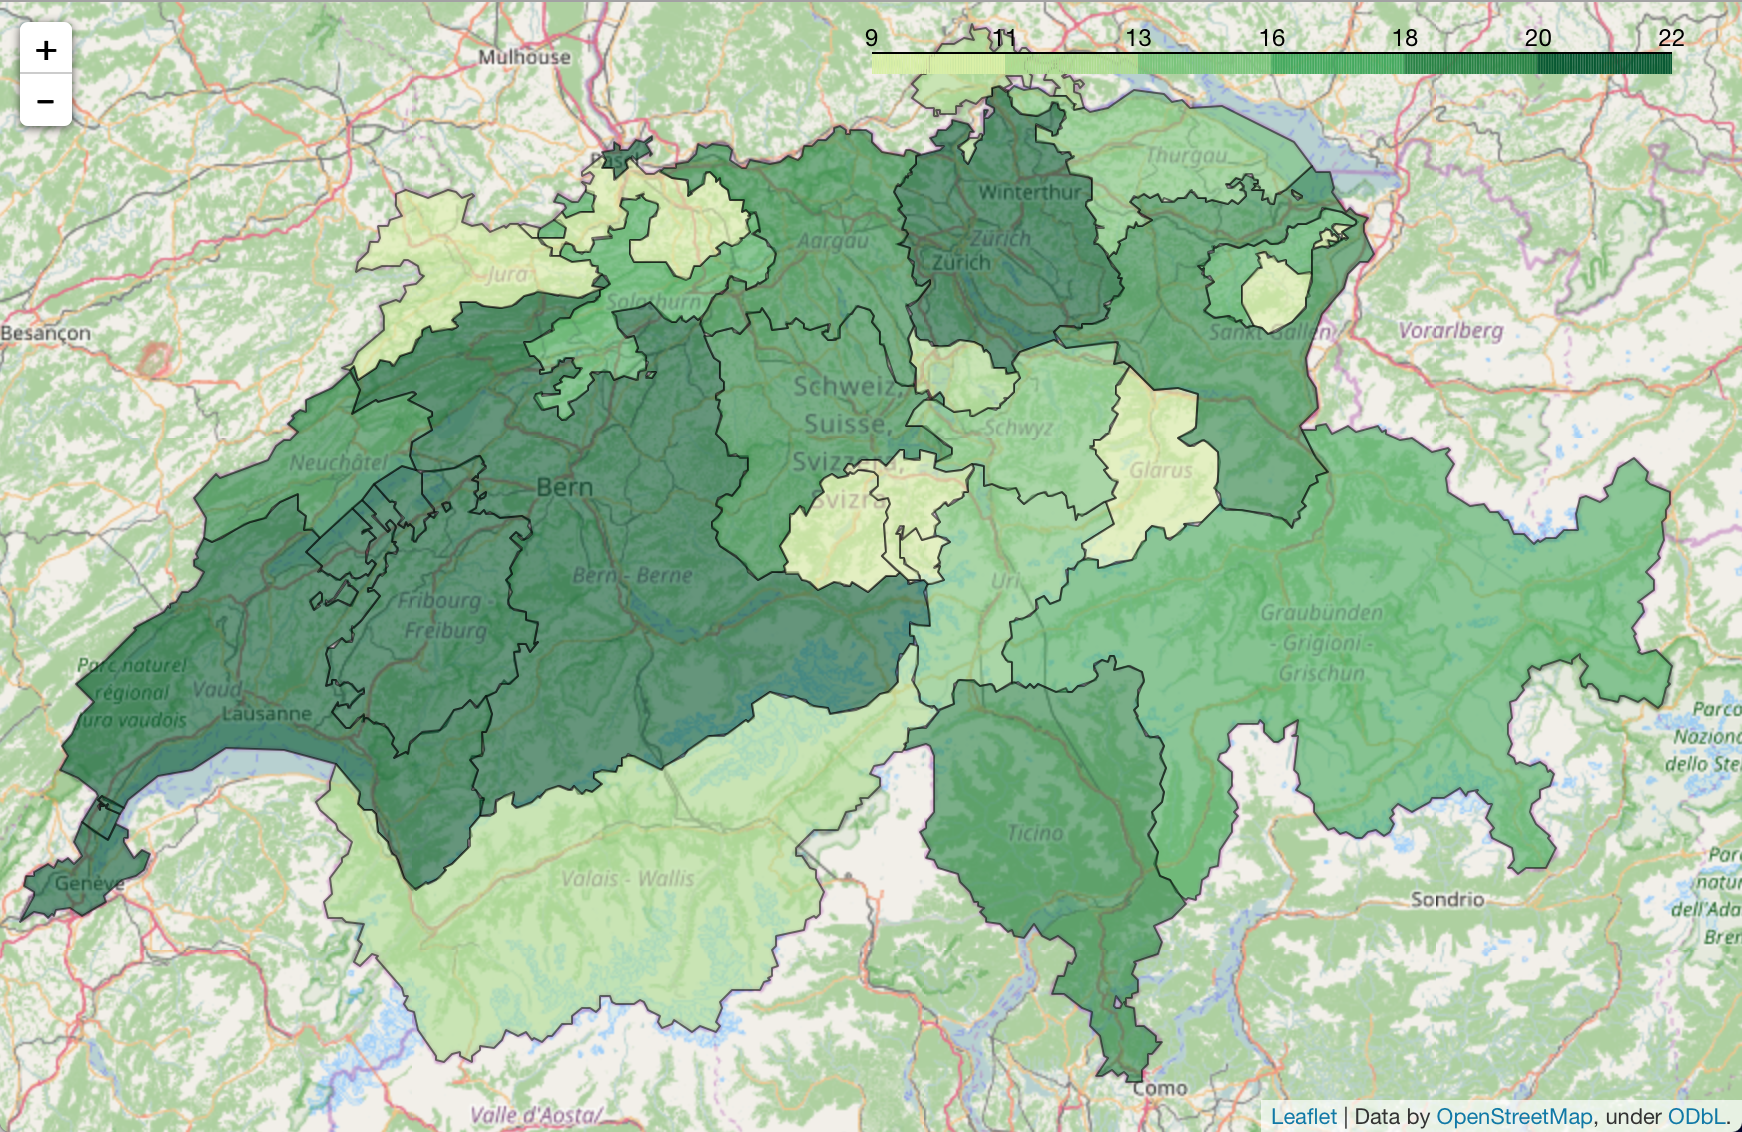

In [27]:
from IPython.display import Image
Image("./map.png")